
### Importing Pytorch module



In [1]:
from torch import nn
from torch.nn import functional as F
import torch
from torch.utils.data import DataLoader,Dataset
from torch import tensor
from torch.optim import Adam

### Other packages

In [44]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
import shutil
import random
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pandas as pd

### Checking GPU and moving data to GPU if available

In [3]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Loading Dataset and Preprocessed files

In [6]:
with open('/content/embed_tensor.pkl','rb') as f:
    embed_tensor=pickle.load(f)
with open('/content/imdb.pkl','rb') as f:
    reviews=pickle.load(f)
with open('/content/index_to_word.pkl','rb') as f:
    index_to_word=pickle.load(f)
with open('/content/word_to_index.pkl','rb') as f:
    word_to_index=pickle.load(f)

embed_tensor= embed_tensor.to(device)

In [7]:
def datasplit(reviews):
    y=[]
    for i in reviews:
        y.append(i[1])
    train_set, val_set, _ , _ = train_test_split(reviews, y, test_size=0.1, random_state=42)
    return train_set,val_set

train,val=datasplit(reviews)

In [8]:
class ReviewSet(Dataset):
    def __init__(self,dataset):
        self.dataset=dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self,idx):
        return torch.tensor(self.dataset[idx][0],dtype=torch.int64),self.dataset[idx][1]

train_set=ReviewSet(train)
val_set=ReviewSet(val)

In [9]:
def moveToDevice(x,y):
    return x.to(device),y.to(device)

### Building the model

In [16]:
class Model(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers):
        super(Model,self).__init__()
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        # Model Structure
        self.embed=nn.Embedding(num_embeddings=embed_tensor.shape[0],embedding_dim=input_size,padding_idx=0)
        self.embed.from_pretrained(embed_tensor)
        self.embed.weight.requires_grad=False
        self.lstm=nn.LSTM(input_size,hidden_size,num_layers=num_layers,batch_first=True,bidirectional=True)
        self.dense1=nn.Linear(in_features=hidden_size*2,out_features=2)

    def forward(self,t):
        t=self.embed(t)
        batch_size=t.shape[0]
        h0=torch.zeros(self.num_layers*2,batch_size,self.hidden_size).to(device)
        c0=torch.zeros(self.num_layers*2,batch_size,self.hidden_size).to(device)
        t,_=self.lstm(t,(h0,c0))

        t1= torch.max(t,dim=1)     # Max pooling
        t2= torch.mean(t,dim=1)    # Average Pooling
        t= t1+t2
        t=F.dropout(t,0.3)
        return self.dense1(t)
model=Model(embed_tensor.shape[1],128,1)
model.to(device)

Model(
  (embed): Embedding(15001, 50, padding_idx=0)
  (lstm): LSTM(50, 128, batch_first=True, bidirectional=True)
  (dense1): Linear(in_features=256, out_features=2, bias=True)
)

### Training the model

In [11]:
os.mkdir('./weights')

In [17]:
batch_size=64
epochs=30
optim= Adam(model.parameters(),lr=0.0001)

In [13]:
def accuracy(preds,labels):
    return (torch.argmax(preds,dim=1)==labels).sum().item()

In [14]:
total_size=len(reviews)
train_size=len(train)
val_size=len(val)

In [18]:
train_losses=[]
val_losses=[]
train_acc=[]
val_acc=[]
train_step= train_size//batch_size
val_step=val_size//batch_size
for i in range(epochs):
    # Training
    tloss=0
    vloss=0
    tacc=0
    vacc=0
    train_dl=DataLoader(train_set,batch_size,shuffle=True)
    val_dl=DataLoader(val_set,batch_size,shuffle=True)
    for x,y in train_dl:
        x,y = moveToDevice(x,y)
        optim.zero_grad()
        y_pred=model(x)
        loss=F.cross_entropy(y_pred,y)
        loss.backward()
        optim.step()
        tloss+=loss.item()
        tacc+=accuracy(y_pred,y)
    tloss/=train_step
    tacc=tacc/train_size
    train_losses.append(tloss)
    train_acc.append(tacc)
    # Validating
    with torch.no_grad():
        for x,y in val_dl:
            x,y = moveToDevice(x,y)
            y_pred=model(x)
            loss=F.cross_entropy(y_pred,y)
            vloss+=loss.item()
            vacc+=accuracy(y_pred,y)
        vloss/=val_step
        vacc=vacc/val_size
        val_losses.append(vloss)
        val_acc.append(vacc)
    print('training loss={}, training accuracy={}, val loss={}, val accuracy={} '.format(tloss,tacc,vloss,vacc))
    torch.save(model.state_dict(), 'weights/epoch_{}.pth'.format(i+1))

training loss=0.6695964235075846, training accuracy=0.5934888888888888, val loss=0.632064931667768, val accuracy=0.6642 
training loss=0.5897814013795188, training accuracy=0.6890888888888889, val loss=0.5801141846638459, val accuracy=0.701 
training loss=0.5320959816107879, training accuracy=0.7365777777777778, val loss=0.5132493942211835, val accuracy=0.7552 
training loss=0.47787372494490016, training accuracy=0.7750666666666667, val loss=0.47117452781934005, val accuracy=0.7756 
training loss=0.4412183894710893, training accuracy=0.7952, val loss=0.44069403333541673, val accuracy=0.8036 
training loss=0.4143971139896306, training accuracy=0.8113777777777778, val loss=0.4244639197221169, val accuracy=0.808 
training loss=0.39820215765222544, training accuracy=0.8220222222222222, val loss=0.41720868265017486, val accuracy=0.815 
training loss=0.38202275751240733, training accuracy=0.8301111111111111, val loss=0.4052038735304123, val accuracy=0.8172 
training loss=0.3715051596568285, 

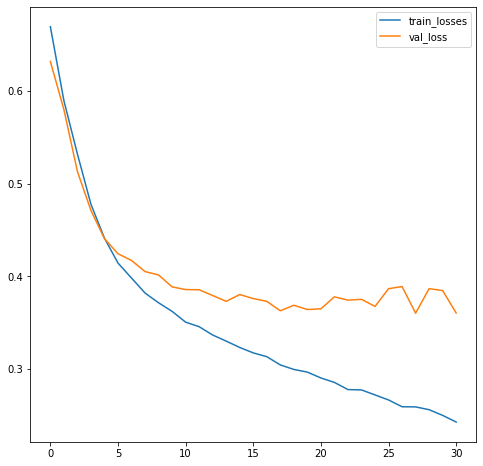

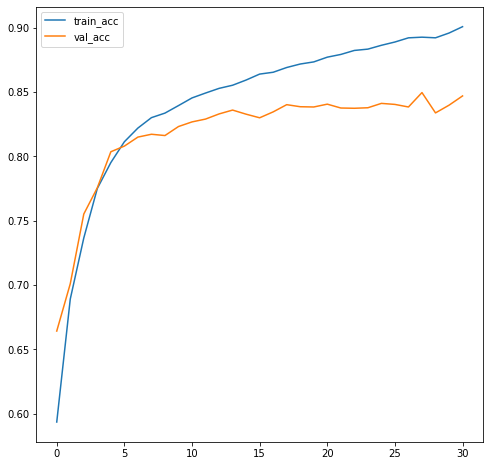

In [19]:
plt.figure(figsize=(8,8))
plt.plot(train_losses,label='train_losses')
plt.plot(val_losses,label='val_loss')
plt.legend()
plt.show()
plt.figure(figsize=(8,8))
plt.plot(train_acc,label='train_acc')
plt.plot(val_acc,label='val_acc')
plt.legend()
plt.show()

### Evaluating model on complete dataset

In [24]:
#Finding epoch with lowest validation loss
best_epoch=np.argmin(val_losses)+1
best_epoch

28

In [25]:
model.load_state_dict(torch.load(f'weights/epoch_{best_epoch}.pth'))
model.eval()

Model(
  (embed): Embedding(15001, 50, padding_idx=0)
  (lstm): LSTM(50, 128, batch_first=True, bidirectional=True)
  (dense1): Linear(in_features=256, out_features=2, bias=True)
)

In [45]:
def checkMetrics(model,reviews,batch_size):
    dl=DataLoader(ReviewSet(reviews),batch_size)
    step=len(reviews)//batch_size
    total_loss=0
    acc=0
    y_true=[]
    y_pred=[]
    idx_to_label={0:'negative',1:'positive'}
    with torch.no_grad():
        for x,y in dl:
            x,y = moveToDevice(x,y)
            y_=model(x)
            loss=F.cross_entropy(y_,y)
            total_loss+=loss.item()
            acc+=accuracy(y_,y)
            y_=torch.argmax(y_,dim=1).cpu().numpy()
            for i in range(batch_size):
                y_true.append(idx_to_label[y[i].cpu().item()])
                y_pred.append(idx_to_label[y_[i]])
        total_loss/=step
        acc/=len(reviews)
    #Confusion Matrix
    col=np.unique(y_true)
    mat=metrics.confusion_matrix(y_true,y_pred)
    data={col[n]+'-Pred':mat.T[n] for n in range(len(col))}
    df=pd.DataFrame(data)
    df.index=[i+'-Real' for i in col]
    result={'pred':y_pred,'loss':total_loss,'acc':acc,'metrics':metrics.classification_report(y_true,y_pred),'confusion_matrix':df}
    return result

In [ ]:
result=checkMetrics(model,reviews,50)

In [47]:
print(f"Loss={result['loss']}, Accuracy={result['acc']}")
print(result['metrics'])

Loss=0.25254061636328695, Accuracy=0.89488
              precision    recall  f1-score   support

    negative       0.91      0.88      0.89     25000
    positive       0.88      0.91      0.90     25000

    accuracy                           0.89     50000
   macro avg       0.90      0.89      0.89     50000
weighted avg       0.90      0.89      0.89     50000



In [48]:
result['confusion_matrix']

,negative-Pred,positive-Pred
negative-Real,21984,3016
positive-Real,2240,22760
